<a href="https://colab.research.google.com/github/p-ai-org/p-music/blob/main/album_metadata_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
#import re
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.compose import make_column_transformer
#from sklearn.model_selection import GroupShuffleSplit

#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras import callbacks

ds = pd.read_csv('merged_features.csv')

In [3]:
ds.shape
ds = ds.drop('Unnamed: 0', axis = 1)
ds.columns

Index(['Ranking', 'Album', 'Artist', 'Release Date', 'Genres', 'Descriptors',
       'Average Rating', 'Number of Ratings', 'Number of Reviews',
       'Release Month', 'Release Day', 'Release Year', 'Format', 'Label',
       'Genre', 'Metacritic Critic Score', 'Metacritic Reviews',
       'Metacritic User Score', 'Metacritic User Reviews', 'AOTY Critic Score',
       'AOTY Critic Reviews', 'AOTY User Score', 'AOTY User Reviews'],
      dtype='object')

In [4]:
#use an average of AOTY and metacritic user score (the same goes with critic)
#if one of them is missing, use the other
#if both are missing, drop that row
col_list = ['AOTY Critic Score', 'Metacritic User Score', 'AOTY User Score', 'Metacritic Critic Score', 'Metacritic User Reviews', 'AOTY User Reviews', 'AOTY Critic Reviews', 'Metacritic Reviews']
ds[col_list] = ds[col_list].fillna(0)
ds[:5]

,Ranking,Album,Artist,Release Date,Genres,Descriptors,Average Rating,Number of Ratings,Number of Reviews,Release Month,...,Label,Genre,Metacritic Critic Score,Metacritic Reviews,Metacritic User Score,Metacritic User Reviews,AOTY Critic Score,AOTY Critic Reviews,AOTY User Score,AOTY User Reviews
0,1.0,OK Computer,Radiohead,16 June 1997,"Alternative Rock, Art Rock","melancholic, anxious, futuristic, alienation, ...",4.23,"70,382",1531,June,...,"Parlophone, Capitol",Alternative Rock,0.0,0.0,0.0,0.0,91,12,93,3204
1,2.0,Wish You Were Here,Pink Floyd,12 September 1975,"Progressive Rock, Art Rock","melancholic, atmospheric, progressive, male vo...",4.29,"48,662",983,September,...,Harvest,Progressive Rock,0.0,0.0,0.0,0.0,100,4,91,1607
2,4.0,Kid A,Radiohead,3 October 2000,"Art Rock, Experimental Rock, Electronic","cold, melancholic, futuristic, atmospheric, an...",4.21,"58,590",734,October,...,Capitol / EMI,Experimental Rock,80.0,24.0,8.9,1129.0,85,13,92,2862
3,5.0,To Pimp a Butterfly,Kendrick Lamar,15 March 2015,"Conscious Hip Hop, West Coast Hip Hop, Jazz Rap","political, conscious, poetic, protest, concept...",4.27,"44,206",379,March,...,Aftermath / Interscope,Hip Hop,96.0,44.0,8.8,3616.0,95,42,93,4530
4,6.0,Loveless,My Bloody Valentine,4 November 1991,"Shoegaze, Noise Pop","noisy, ethereal, atmospheric, romantic, dense,...",4.24,"49,887",1223,November,...,Creation,Shoegaze,0.0,0.0,0.0,0.0,94,9,91,1634


In [5]:
critic_score = ['AOTY Critic Score', 'Metacritic Critic Score'] #if we expand dataset then these lists will have more items
user_score = ['AOTY User Score', 'Metacritic User Score']
critic_reviews = ['AOTY Critic Reviews', 'Metacritic Reviews']
user_reviews = ['AOTY User Reviews', 'Metacritic User Reviews']
merge_list = [critic_score, user_score, critic_reviews, user_reviews]

In [6]:
#tried curried function but chain indexing became a problem
#uncurried version below
def scoreMergeUncurried(col_list):
  merged_score = []
  for x in ds.index:
    if ds.loc[x, col_list[0]]==0 and ds.loc[x, col_list[1]]==0 : #both values filled with 0
     merged_score.append(sum(merged_score)/len(merged_score)) #switch to substitution
    elif ds.loc[x, col_list[0]]==0:
      merged_score.append(ds.loc[x, col_list[1]])
    elif ds.loc[x, col_list[1]]==0:
      merged_score.append(ds.loc[x, col_list[0]])
    else: #neither missing -> use mean
      merged_score.append((ds.loc[x, col_list[0]]+ds.loc[x, col_list[0]])/2)
  return merged_score
  
  #df['new_col] = scoreMergeUncurried(col_list)

In [7]:
ds['merged_critic_score'] = scoreMergeUncurried(critic_score)
ds['merged_user_score'] = scoreMergeUncurried(user_score)
ds['merged_critic_reviews'] = scoreMergeUncurried(critic_reviews)
ds['merged_user_reviews'] = scoreMergeUncurried(user_reviews)

#drop originals at once here
ds = ds.drop(col_list, axis=1)

In [8]:
#numberify(?) release year. fill in mean if missing (these aren't highly correlated with the output anyway)

ds['Release Year'] = ds['Release Date'].str.replace("-", "").apply(lambda x: x[-2:])
ds['Release Year'] = [x if x.isnumeric() else np.nan for x in ds['Release Year']]
ds['Release Year'] =  [x+2000 if x<23 and x != np.nan else x+1900 for x in ds['Release Year'].astype('int64')]
ds['Release Year'].isna().any()

#convert number of ratings into number data type
ds['Number of Ratings'] = ds['Number of Ratings'].str.replace(',', '').astype('int64')
#ds['Number of Ratings'].isna().any()
#
#drop release date and month and day (date: redundant with year, month and day have almost no correlation with output)
ds = ds.drop(['Release Date', 'Release Month', 'Release Day'], axis = 1)



In [9]:
#for each row in ds["Genre"]
#if value is missing
#replace with first value in ds["Genres"]

missing_genre = ds.loc[ds["Genre"].isna()]
for x in missing_genre.index:
  ds.loc[x, 'Genre'] = ds.loc[x, 'Genres'][0]

for x in ds.index:
  if "," in ds.loc[x, 'Genre']:
    ds.loc[x, 'Genre'] = ds.loc[x, 'Genre'].split(',')[0]


In [10]:
def catClean(col):
  top_list = col.value_counts()[:20].index.tolist()
  col = col.fillna("None")
  new_col = col.apply(lambda row: row.split(', ')[0])
  new_col2 = new_col.map(lambda row: "Other" if (row not in set(top_list)) else row)
  return new_col2

In [11]:
ds['Descriptors'] = catClean(ds['Descriptors'])
ds["Descriptors"][:5]
#len(ds["Descriptors"].loc[lambda x: x=="Other"])
#More than half of descriptors don't belong to the top 20
#col = ds["Descriptors"].map(lambda row: "Other" if (row not in set(top_list)) else row) #this changes the value in the series
#col[:10]

0    Other
1    Other
2    Other
3    Other
4    Other
Name: Descriptors, dtype: object

In [12]:
ds["Label"] =  catClean(ds['Label'])
len(ds["Label"].loc[lambda x: x=="Other"])

1792

In [13]:
"""
#class boundaries from CNN
class_list = [[0.627, 0.793], [0.793, 0.818], [0.818, 0.841], [0.841, 0.930]]

def ratingScaler(row):
  for item in class_list:
    if item[0] <= (row/5) and (row/5) < item[1]:
      idx = class_list.index(item)
      return idx
    
ds['Average Rating'] = ds['Average Rating'].apply(ratingScaler)
"""

"\n#class boundaries from CNN\nclass_list = [[0.627, 0.793], [0.793, 0.818], [0.818, 0.841], [0.841, 0.930]]\n\ndef ratingScaler(row):\n  for item in class_list:\n    if item[0] <= (row/5) and (row/5) < item[1]:\n      idx = class_list.index(item)\n      return idx\n    \nds['Average Rating'] = ds['Average Rating'].apply(ratingScaler)\n"

In [14]:
ds.isna().any()

Ranking                  False
Album                    False
Artist                   False
Genres                   False
Descriptors              False
Average Rating           False
Number of Ratings        False
Number of Reviews        False
Release Year             False
Format                   False
Label                    False
Genre                    False
merged_critic_score      False
merged_user_score        False
merged_critic_reviews    False
merged_user_reviews      False
dtype: bool

In [15]:
#data processing for XGBoost
from sklearn.model_selection import train_test_split

y = ds['Average Rating']
X = ds.drop(['Average Rating'], axis=1)

num_features = X.select_dtypes(include=np.number).columns
#print("Num_features: ",num_features)

cat_features = X.select_dtypes(include=object).columns
#print("cat_features: ",cat_features)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

In [16]:
from xgboost import XGBRegressor

# Define the model
my_model = XGBRegressor(random_state=0) # Your code here

# Fit the model
my_model.fit(X_train, y_train, early_stopping_rounds = 10, eval_set = [(X_valid, y_valid)]) # Your code here

[21:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.95757
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.66228
[2]	validation_0-rmse:2.39717
[3]	validation_0-rmse:2.15824
[4]	validation_0-rmse:1.94344
[5]	validation_0-rmse:1.74987
[6]	validation_0-rmse:1.57575
[7]	validation_0-rmse:1.41894
[8]	validation_0-rmse:1.27803
[9]	validation_0-rmse:1.1509
[10]	validation_0-rmse:1.03655
[11]	validation_0-rmse:0.933482
[12]	validation_0-rmse:0.84072
[13]	validation_0-rmse:0.757165
[14]	validation_0-rmse:0.682144
[15]	validation_0-rmse:0.61456
[16]	validation_0-rmse:0.553708
[17]	validation_0-rmse:0.498837
[18]	validation_0-rmse:0.449362
[19]	validation_0-rmse:0.404993
[20]	validation_0-rmse:0.365143
[21]	validation_0-rmse:0.328997
[22]	validation_0-rmse:0.29661
[23]	validation_0-rmse:0.26753
[24]	validation_0-rmse:0.241321
[25]	validation_0-rmse:0.217647
[2

XGBRegressor()

In [17]:
from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(X_valid)
mae = mean_absolute_error(predictions, y_valid)
mae

0.009409460753073423

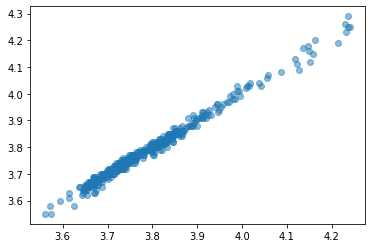

In [26]:
import matplotlib.pyplot as plt

plt.scatter(predictions, y_valid,  alpha=0.5)

In [18]:
"""
#data processing: based on kaggle learn deep learning course. didn't work
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

X = ds.copy()
y = X.pop('Average Rating')
print("X shape:", X.shape)

num_features = X.select_dtypes(include=np.number).columns
#print("Num_features: ",num_features)

cat_features = X.select_dtypes(include=object).columns
#print("cat_features: ",cat_features)

num_transformer = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
cat_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="None"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.85)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
#large number of columns due to onehot encoding. trim if necessary
print(input_shape)
"""

'\n#data processing: based on kaggle learn deep learning course. didn\'t work\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.compose import make_column_transformer\n\nX = ds.copy()\ny = X.pop(\'Average Rating\')\nprint("X shape:", X.shape)\n\nnum_features = X.select_dtypes(include=np.number).columns\n#print("Num_features: ",num_features)\n\ncat_features = X.select_dtypes(include=object).columns\n#print("cat_features: ",cat_features)\n\nnum_transformer = make_pipeline(\n    SimpleImputer(strategy="constant"), # there are a few missing values\n    StandardScaler(),\n)\ncat_transformer = make_pipeline(\n    SimpleImputer(strategy="constant", fill_value="None"),\n    OneHotEncoder(handle_unknown=\'ignore\'),\n)\n\npreprocessor = make_column_transformer(\n    (num_transformer, num_features),\n    (cat_transformer, cat_fea

In [19]:
"""
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),

    model.compile(optimizer = "adam", loss = "mae")
])    

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=50
)
"""

'\nfrom tensorflow.keras import layers\n\nmodel = keras.Sequential([\n    layers.Dense(512, activation=\'relu\', input_shape=input_shape),\n    layers.Dense(512, activation=\'relu\'),\n    layers.Dense(512, activation=\'relu\'),\n    layers.Dense(1),\n\n    model.compile(optimizer = "adam", loss = "mae")\n])    \n\nhistory = model.fit(\n    X_train, y_train,\n    validation_data=(X_valid, y_valid),\n    batch_size=256,\n    epochs=50\n)\n'

In [20]:
#one-hot encoding for entries with multiple items
#abandoned this idea because it was more complicated than I expected and didn't seem to be worth extra processing power
#go for the simpler solution if I have two different solution
# 1 if item is in each row entry, 0 if not

#create list of top 20 items by frequency

"""


#if entry has multiple words, split it into list
def wordSplit(row):
  if "," in row:
    row = row.split(', ')

#input unprocessed col
def makeList(col):
  item_counts =col.value_counts()
  #print(item_counts[:5])
  top_list = item_counts.index[:20].tolist()
  return top_list



#input processed col here
def makeDf(col):
  #dict will go into new df
  item_dict = {}
  for item in top_list:
    item_dict[item] = []
  for item in top_list: #for each item in top_list, append 1 to entry if item is in the row
    item_dict[item] = [1 if (item in set(row)) else 0 for row in set(col)]
    print(item, "+" , item_dict[item])
  item_df = pd.DataFrame.from_dict(item_dict)
  return item_df
  """

'\n\n\n#if entry has multiple words, split it into list\ndef wordSplit(row):\n  if "," in row:\n    row = row.split(\', \')\n\n#input unprocessed col\ndef makeList(col):\n  item_counts =col.value_counts()\n  #print(item_counts[:5])\n  top_list = item_counts.index[:20].tolist()\n  return top_list\n\n\n\n#input processed col here\ndef makeDf(col):\n  #dict will go into new df\n  item_dict = {}\n  for item in top_list:\n    item_dict[item] = []\n  for item in top_list: #for each item in top_list, append 1 to entry if item is in the row\n    item_dict[item] = [1 if (item in set(row)) else 0 for row in set(col)]\n    print(item, "+" , item_dict[item])\n  item_df = pd.DataFrame.from_dict(item_dict)\n  return item_df\n  '